In [1]:
import os
import numpy as np
import pandas as pd
import random
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from PIL import Image

In [2]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))

fix_layout()

In [3]:
def draw_labels(image, labels_df, thickness, color, fill_poly):
    for row in range(labels_df.shape[0]):
        pts = np.array(labels_df.loc[row]).reshape((-1,1,2))
        if fill_poly:
            image = cv.fillPoly(image, np.int32([pts]), color=rgb(color))
        else:
            image = cv.polylines(image, np.int32([pts]), True, color=rgb(color), thickness=thickness)
    
    return image

In [4]:
def rgb(hex_color):
    return tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))

In [5]:
thickness = 5
magnet_color = "#00cccc"
tissue_color = "#ff6666"

fill_poly = False

In [6]:
DATASET_NUMBER = 1

AUGMENTED_DATASET_PATH = "../augmented_dataset"
WAFER_CROPPED_PATH = f"{AUGMENTED_DATASET_PATH}/fluo_cropped_{str(DATASET_NUMBER)}"
TEST_IMAGES_PATH = "test_images"

### Cropped Section Example

In [7]:
path_img= f"{WAFER_CROPPED_PATH}/extract/0.tiff"
if os.path.isfile(path_img):
    section = cv.imread(path_img,0)
else:
    print ("The file " + path_img + " does not exist.")

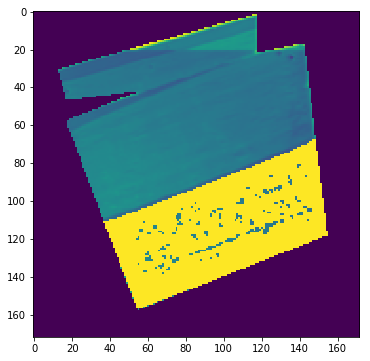

In [8]:
plt.figure(figsize=(8, 6))
plt.imshow(section)

In [9]:
section.shape

(172, 172)

In [10]:
height_section = section.shape[0]
width_section = section.shape[1]

In [11]:
init_img = np.zeros([height_section,width_section],dtype=np.uint8)
sub = init_img

In [12]:
# Boolean matrix which is true is not 0 (the pixel has a value, and is the potentially the object)
ind_true = section > 0

In [13]:
for i in range(height_section):
    for j in range(width_section):
        if(ind_true[i,j]):
            sub[i,j] = section[i,j]
        else:
            sub[i,j] = 0

In [73]:
for i in range(height_section):
    for j in range(width_section):
        if(sub[i,j] < 25):
            sub[i,j] = 122

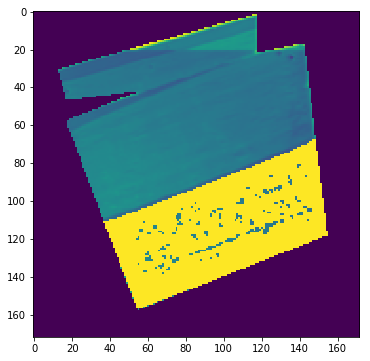

In [14]:
plt.figure(figsize=(8, 6))

plt.imshow(sub)

In [15]:
cv.imwrite("test.tiff", sub)

True

In [16]:
if os.path.exists("test.tiff"):
    os.remove("test.tiff")

### Load Segmentation Boxes 

To create artificial image we will load section with the associated segmentation boxes coordinates. 
In this example we're working only with the dataset1. Hence we load the seg. boxes for the dataset1.

In [17]:
index = pd.MultiIndex.from_tuples([('point_1', 'x'), ('point_1', 'y'), ('point_2', 'x'), ('point_2', 'y'),
                                   ('point_3', 'x'), ('point_3', 'y'), ('point_4', 'x'), ('point_4', 'y')])

In [18]:
boxes_tissues_dataset1 = pd.read_csv(f"{WAFER_CROPPED_PATH}/boxes_tissues.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
boxes_tissues_dataset1.head()

point_1      point_2     point_3     point_4    
        x    y       x   y       x   y       x   y
0      36  110      16  58     142  16     148  67
1      40  114      16  64     141  16     150  65
2      38  110      16  59     143  16     149  66
3      45  126      16  78     132  16     147  66
4      44  123      16  75     136  16     148  65

In [19]:
boxes_mag_dataset1 = pd.read_csv(f"{WAFER_CROPPED_PATH}/boxes_mag.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
boxes_mag_dataset1.head()

point_1      point_2      point_3     point_4     
        x    y       x    y       x   y       x    y
0      55  156      37  112     148  68     156  118
1      61  160      42  117     149  67     160  114
2      58  156      39  111     150  67     158  115
3      71  171      46  128     146  66     163  113
4      68  166      44  124     148  66     162  113

### Collision Detection

Method able to check only the interesting part of a section (not the background) and output the 'collision boxes' for this section.
We'll then be able to compare these collision boxes to check whether the section will collide with other sections in the full image

In [20]:
def get_collision_boxes(section,nb_boxes = 4, draw = False):
    #Divide the section into 5 block 
    height_section = section.shape[0]
    width_section = section.shape[1]
    

    limit_boxes = np.zeros([nb_boxes,4],dtype=np.uint16)
    
    cut_height = (height_section//nb_boxes)+1
    for cuts in range(nb_boxes):
        i=0

        if((cuts)*cut_height + 4 >= height_section):
            limit_boxes[cuts] = limit_boxes[cuts-1]
        
        else:
            ymax_box = (cuts+1)*cut_height
            if(ymax_box >= height_section):
                ymax_box = height_section-1
                temp_cut_height = height_section - cut_height*(cuts)
            else:
                temp_cut_height = cut_height
            
            
            # y Min
            for i in range(temp_cut_height):
                if( (np.mean( section[i + cuts*cut_height] ) != 0)):
                    limit_boxes[cuts,0] = i+cuts*cut_height
                    break
            # y Max

            for i in range(cut_height):
                if(np.mean(section[ymax_box-i-1]) != 0):
                    limit_boxes[cuts,1] = ymax_box-i
                    break
            # x Min
            for i in range(width_section):
                if( np.mean( section[ cuts*cut_height+1 : ymax_box , i] ) != 0):
                    limit_boxes[cuts,2] = i
                    break
            # x Max
            for i in range(width_section-1,0,-1):
                if(np.mean(section[cuts*cut_height+1:ymax_box,i]) != 0):
                    limit_boxes[cuts,3] = i
                    break

            # Prevent empty slices
            if(np.mean(limit_boxes[cuts]) == 0 ):
                limit_boxes[cuts] = limit_boxes[cuts - 1]
            if(limit_boxes[cuts,2] == limit_boxes[cuts,3] ):
                limit_boxes[cuts,3] = limit_boxes[cuts,3]+1
            
            for i in range(min(cuts,5)):
                if(np.mean(limit_boxes[cuts-(i+1)]) <= 1 ):
                    limit_boxes[cuts-(i+1)] = limit_boxes[cuts]
            

            
            if((limit_boxes[cuts,2] <= 1) and  (limit_boxes[cuts,3] <= 1)):
                limit_boxes[cuts] = limit_boxes[cuts - 1]
            

        
          
        if(draw):
            pts = np.array([limit_boxes[cuts,2],limit_boxes[cuts,0], limit_boxes[cuts,3],limit_boxes[cuts,0], limit_boxes[cuts,3],limit_boxes[cuts,1], limit_boxes[cuts,2],limit_boxes[cuts,1] ] )
            pts = pts.reshape((-1,1,2))
            section = cv.polylines(section, np.int32([pts]), True, color=rgb(tissue_color), thickness=1)
            plt.imshow(section, cmap='gray')
    return limit_boxes
        

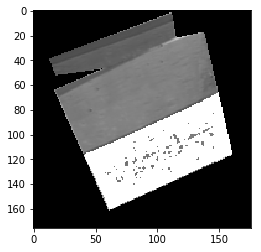

In [21]:
path_img= f"{WAFER_CROPPED_PATH}/extract/1.tiff"
section = cv.imread(path_img,0)
plt.imshow(section, cmap='gray')

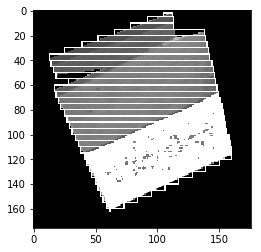

In [22]:
t = get_collision_boxes(section,40,True)

### Create Artificial Image

Extract randomly section and place it randomly in the image. For each section, compute and store the segmentation boxes coordinates of the section (brain + mag)

In [127]:
path_img= f"{AUGMENTED_DATASET_PATH}/background_1.tif"
if os.path.isfile(path_img):
    backgnd = cv.imread(path_img, 0)
else:
    print ("The file " + path_img + " does not exist.")

In [128]:
path_img= f"{AUGMENTED_DATASET_PATH}/background_2.tif"
if os.path.isfile(path_img):
    backgnd_2 = cv.imread(path_img, 0)
else:
    print ("The file " + path_img + " does not exist.")

In [129]:
# Size of the image
print(backgnd.shape)
height, width = backgnd.shape[0]*10, backgnd.shape[1]*10  # means 10x10 background images
print(height, width)
full_image = np.zeros([height, width],dtype=np.uint8)
full_image.fill(0)

(311, 416)
3110 4160


In [130]:
random.seed(22)

In [131]:
# NB of artificial images to create
nb_artificial_images = 20
random.seed(22)

In [147]:
for iter_img in range(nb_artificial_images): 
    height, width = backgnd.shape[0]*10, backgnd.shape[1]*10  # means 10x10 background images
    full_image = np.zeros([height, width],dtype=np.uint8)
    full_image.fill(0)
    
    nb_sections = random.randint(230, 300)
    print(nb_sections)
    f_seg_tissues_artif = open(f"{AUGMENTED_DATASET_PATH}/artificial_images/seg_tissues_artif3_{iter_img}.txt","w+")
    f_seg_mag_artif= open(f"{AUGMENTED_DATASET_PATH}/artificial_images/seg_mag_artif3_{iter_img}.txt","w+")

    for index_section in range(nb_sections):

        # Section selection
        # section_num will be use to load the data image, and to load the corrects segmentation boxes
        section_num = random.randint(1, 70)
        print(section_num)


        path_img= f"{WAFER_CROPPED_PATH}/extract/{str(section_num)}.tiff"
        section = cv.imread(path_img,0)
        height_section = section.shape[0]
        width_section = section.shape[1]


        xpos_section = random.randint(100, 3700)
        ypos_section = random.randint(100, 2600)
        
        # Collision boxes to not interfere with other sections
        nb_collision_boxes = 30
        collision_boxes_section = get_collision_boxes(section, nb_collision_boxes, False)

        free_place = True
        for i in range(nb_collision_boxes):
            
            ymin = ypos_section+collision_boxes_section[i][0]
            ymax = ypos_section+collision_boxes_section[i][1]
            xmin = xpos_section+collision_boxes_section[i][2]
            xmax = xpos_section+collision_boxes_section[i][3]

            # check collision box 
            if(np.mean(full_image[ymin:ymax, xmin:xmax]) != 0):
                free_place = False



        # Find an area in the image free (all pixels = 255)
        timeout = 0

        while(free_place == False):
            xpos_section = random.randint(500, 3500)
            ypos_section = random.randint(500, 2500)

            free_place = True
            for i in range(nb_collision_boxes):
                #print(i)
                ymin = ypos_section+collision_boxes_section[i][0]
                ymax = ypos_section+collision_boxes_section[i][1]
                xmin = xpos_section+collision_boxes_section[i][2]
                xmax = xpos_section+collision_boxes_section[i][3]


                # check collision box 1
                if(np.mean(full_image[ymin:ymax, xmin:xmax]) != 0):
                    free_place = False

            if(timeout>10000):
                # end loop no more space
                index_section = nb_sections+1 
                print("No more space")
                break
            else:
                timeout= timeout+1

        if(timeout > 10000):
            break


        # Integrate the section into the full image
        for i in range(height_section):
            for j in range(width_section):
                if(section[i,j] != 0):
                    full_image[ypos_section+i,xpos_section+j] = section[i,j]



        #Store the new segmentation position Brain tissues in txt file
        temp_tissue = boxes_tissues_dataset1.iloc[section_num]

        seg_tissues_p1_x = temp_tissue['point_1']['x'] + xpos_section  
        seg_tissues_p1_y = temp_tissue['point_1']['y'] + ypos_section  

        seg_tissues_p2_x = temp_tissue['point_2']['x'] + xpos_section  
        seg_tissues_p2_y = temp_tissue['point_2']['y'] + ypos_section  

        seg_tissues_p3_x = temp_tissue['point_3']['x'] + xpos_section  
        seg_tissues_p3_y = temp_tissue['point_3']['y'] + ypos_section 

        seg_tissues_p4_x = temp_tissue['point_4']['x'] + xpos_section 
        seg_tissues_p4_y = temp_tissue['point_4']['y'] + ypos_section 

        f_seg_tissues_artif.write("%d,%d\t%d,%d\t%d,%d\t%d,%d\r\n" % (seg_tissues_p1_x,seg_tissues_p1_y,  seg_tissues_p2_x,seg_tissues_p2_y,  seg_tissues_p3_x,seg_tissues_p3_y,  seg_tissues_p4_x,seg_tissues_p4_y))

        #Store the new segmentation position Mag in txt file
        temp_mag = boxes_mag_dataset1.iloc[section_num]

        seg_mag_p1_x = temp_mag['point_1']['x'] + xpos_section  
        seg_mag_p1_y = temp_mag['point_1']['y'] + ypos_section  

        seg_mag_p2_x = temp_mag['point_2']['x'] + xpos_section  
        seg_mag_p2_y = temp_mag['point_2']['y'] + ypos_section  

        seg_mag_p3_x = temp_mag['point_3']['x'] + xpos_section  
        seg_mag_p3_y = temp_mag['point_3']['y'] + ypos_section 

        seg_mag_p4_x = temp_mag['point_4']['x'] + xpos_section 
        seg_mag_p4_y = temp_mag['point_4']['y'] + ypos_section 

        f_seg_mag_artif.write("%d,%d\t%d,%d\t%d,%d\t%d,%d\r\n" % (seg_mag_p1_x,seg_mag_p1_y,  seg_mag_p2_x,seg_mag_p2_y,  seg_mag_p3_x,seg_mag_p3_y,  seg_mag_p4_x,seg_mag_p4_y))


    f_seg_tissues_artif.close()
    f_seg_mag_artif.close()
    
    
    # Add background
    width_subbckgnd = backgnd.shape[1]
    height_subbckgnd = backgnd.shape[0]

    for ind_y in range(10):
        for ind_x in range(10):
            # Choice between 2 background
            choice_bckgnd = random.randint(1,2)

            #No objects on the complete background gridcell
            if(np.mean(full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)]) == 0):
                if(choice_bckgnd== 1):
                    full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)] =   backgnd
                else:
                    full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)] =   backgnd_2

            else:
                for i in range(backgnd.shape[0]):
                    for j in range(backgnd.shape[1]):
                        if(full_image[height_subbckgnd*ind_y + i , width_subbckgnd*ind_x + j] == 0):
                            if(choice_bckgnd == 1):
                                full_image[height_subbckgnd*ind_y + i, width_subbckgnd*ind_x + j] = backgnd[i,j]
                            else:
                                full_image[height_subbckgnd*ind_y + i, width_subbckgnd*ind_x + j] = backgnd_2[i,j]
    
    path_artificial_img = f"{AUGMENTED_DATASET_PATH}/artificial_images/artificial_image3_{iter_img}.tif"
    cv.imwrite(path_artificial_img, full_image)
    

297
5
49
42
34
34
64
47
22
27
36
7
12
12
55
51
4
55
33
13
62
44
24
34
13
62
27
26
49
18
27
45
37
63
48
46
53
18
14
58
26
14
36
3
28
No more space
298
58
42
50
40
2
31
66
47
50
51
34
62
8
44
47
49
29
29
8
58
12
4
52
4
30
65
12
28
58
57
42
34
3
56
20
42
54
14
59
9
7
21
51
28
57
42
No more space
234
35
34
30
67
32
27
5
46
48
8
48
44
28
32
31
51
6
67
24
56
31
56
23
26
46
5
51
11
41
49
31
8
63
5
16
22
11
9
41
18
18
44
5
7
No more space
250
8
36
68
30
25
23
32
10
50
23
70
4
5
3
38
63
38
61
54
14
25
28
27
49
41
6
30
32
27
30
30
4
62
23
2
56
4
48
52
62
41
No more space
274
34
11
24
64
25
27
66
16
9
44
67
14
5
38
33
65
7
57
31
12
30
15
19
26
63
61
58
35
13
20
61
64
12
42
7
64
15
46
7
17
No more space
275
60
31
8
69
48
68
26
32
58
60
10
70
41
26
55
54
44
51
22
3
1
34
44
38
27
23
10
66
30
70
19
30
43
46
47
26
27
56
17
58
3
64
No more space
259
57
18
53
49
15
17
44
47
68
2
63
69
53
1
52
39
3
49
48
64
2
41
50
46
14
41
43
18
40
14
68
33
68
30
60
31
49
36
56
69
9
7
49
3
32
52
No more space
280
4
31
5

In [ ]:
plt.figure(figsize=(15, 7))

plt.imshow(full_image)

In [ ]:
cv.imwrite(f"{TEST_IMAGES_PATH}/test_artificial_images.tiff", full_image)

In [ ]:
# remove it since we don't need it in file system
if os.path.exists(f"{TEST_IMAGES_PATH}/test_artificial_images.tiff"):
    os.remove(f"{TEST_IMAGES_PATH}/test_artificial_images.tiff")

### Add Background (already done in previous part)

In [ ]:
path_img= f"{AUGMENTED_DATASET_PATH}/background_1.tif"
if os.path.isfile(path_img):
    backgnd = cv.imread(path_img, 0)
else:
    print ("The file " + path_img + " does not exist.")

In [ ]:
path_img= f"{AUGMENTED_DATASET_PATH}/background_2.tif"
if os.path.isfile(path_img):
    backgnd_2 = cv.imread(path_img, 0)
else:
    print ("The file " + path_img + " does not exist.")

In [ ]:
plt.imshow(backgnd, cmap='gray')

In [ ]:
plt.imshow(backgnd_2, cmap='gray')

In [ ]:
width_subbckgnd = backgnd.shape[1]
height_subbckgnd = backgnd.shape[0]

for ind_y in range(10):
    for ind_x in range(10):
        # Choice between 2 background
        choice_bckgnd = random.randint(1,2)
        
        #No objects on the complete background gridcell
        if(np.mean(full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)]) == 0):
            if(choice_bckgnd== 1):
                full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)] =   backgnd
            else:
                full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)] =   backgnd_2
        
        else:
            for i in range(backgnd.shape[0]):
                for j in range(backgnd.shape[1]):
                    if(full_image[height_subbckgnd*ind_y + i , width_subbckgnd*ind_x + j] == 0):
                        if(choice_bckgnd == 1):
                            full_image[height_subbckgnd*ind_y + i, width_subbckgnd*ind_x + j] = backgnd[i,j]
                        else:
                            full_image[height_subbckgnd*ind_y + i, width_subbckgnd*ind_x + j] = backgnd_2[i,j]
        

In [ ]:
plt.figure(figsize=(40, 30))
plt.imshow(full_image)

In [ ]:
cv.imwrite(f"{TEST_IMAGES_PATH}/test_artificial_images_bckgn.tiff", full_image)

### Segmentation 

Load segmentation boxes recently created for artificial image (brain + mag)

In [148]:
f"{AUGMENTED_DATASET_PATH}/artificial_images/artificial_image_{iter_img}.tif"

'../augmented_dataset/artificial_images/artificial_image_19.tif'

In [25]:
seg_tissues_artif = pd.read_csv(f"{AUGMENTED_DATASET_PATH}/artificial_images/seg_tissues_artif_0.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
seg_tissues_artif.head()

point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    1840  1155    1885  1188    1799  1288    1769  1248
1    2281   750    2222   745    2241   613    2290   631
2    2246  2627    2194  2598    2263  2484    2303  2520
3    1548  2668    1550  2724    1417  2719    1428  2668
4     935  1054     992  1046    1003  1179     953  1172

In [26]:
seg_mag_artif = pd.read_csv(f"{AUGMENTED_DATASET_PATH}/artificial_images/seg_mag_artif_0.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
seg_mag_artif.head()

point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    1799  1124    1840  1154    1769  1248    1735  1209
1    2331   753    2282   750    2290   630    2339   645
2    2291  2650    2247  2627    2301  2520    2341  2551
3    1547  2618    1548  2666    1430  2669    1440  2618
4     887  1061     935  1055     952  1172     902  1167

In [27]:
# Load recently created artificial images
path_img= f"{AUGMENTED_DATASET_PATH}/artificial_images/artificial_image_0.tiff"
if os.path.isfile(path_img):
    extrct_img = cv.imread(path_img)
else:
    print ("The file " + path_img + " does not exist.")

In [28]:
extrct_img = draw_labels(extrct_img, seg_mag_artif, thickness, magnet_color, fill_poly)

In [29]:
extrct_img = draw_labels(extrct_img, seg_tissues_artif, thickness, tissue_color, fill_poly)

In [30]:
legend_elements = [Line2D([0], [0], color=magnet_color, lw=thickness, label='Magnet Part'),
                   Line2D([0], [0], color=tissue_color, lw=thickness, label='Brain Part')]

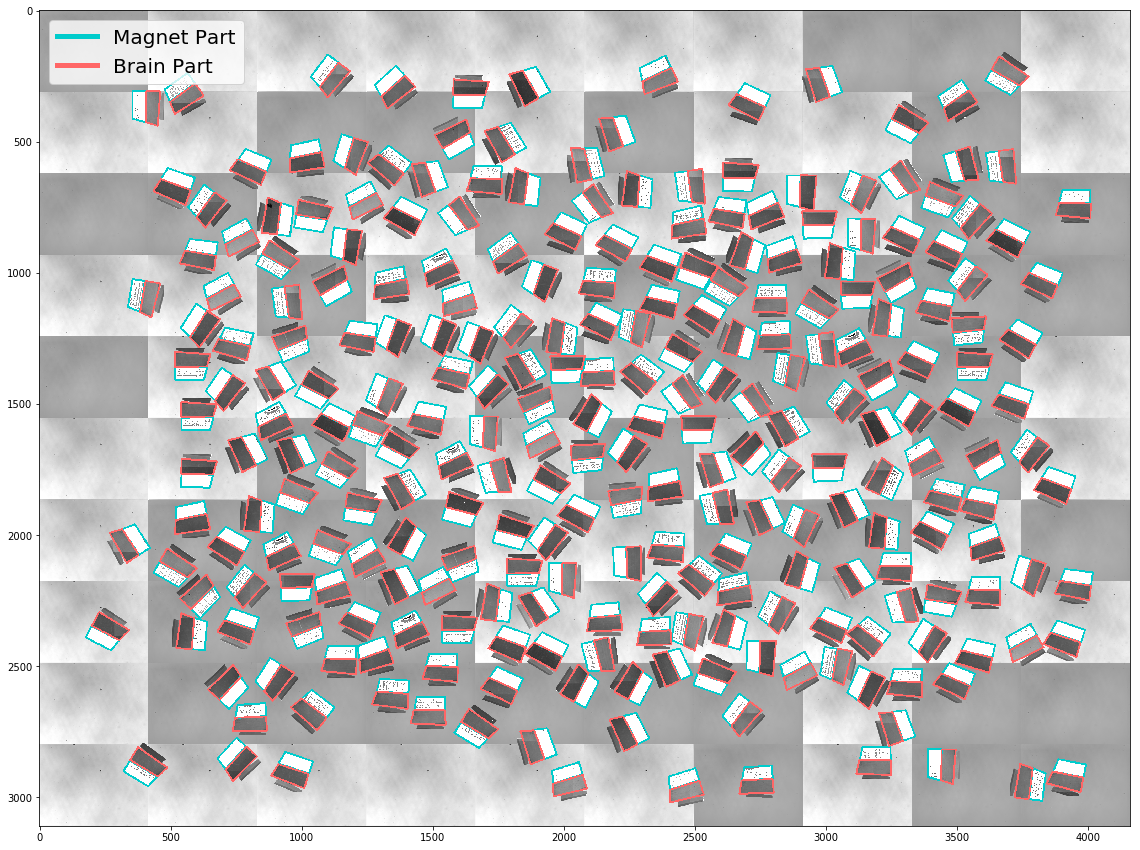

In [31]:
plt.figure(figsize=(20, 15))
plt.imshow(extrct_img)

plt.legend(handles=legend_elements, loc='upper left', fontsize=20)